<a href="https://colab.research.google.com/github/sbb2002/Portfolio/blob/main/.study/Tensorflow/ML_ch12_2_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long sequence RNN

문장을 예측하는 실습. 문장 전체가 아닌 앞 글자 몇 자를 뭐가 나올지 예측한다.

In [ ]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.3MB 46kB/s 
     |████████████████████████████████| 491kB 44.7MB/s 
     |████████████████████████████████| 3.2MB 38.8MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.14.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [ ]:
!pip install tensorflow-gpu==1.14

     |████████████████████████████████| 377.1MB 43kB/s 


In [ ]:
import tensorflow as tf
import numpy as np

tf.set_random_seed(777)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
sample = " if you want you"      # 처음에 한칸 띄워야함
idx2char = list(set(sample))     # idx -> char, set은 순서상관x 중복x
char2idx = {c: i for i, c in enumerate(idx2char)}   # char -> idx

In [ ]:
print(idx2char)
print(char2idx)

['f', 'w', 't', 'a', 'u', 'y', ' ', 'o', 'n', 'i']
{'f': 0, 'w': 1, 't': 2, 'a': 3, 'u': 4, 'y': 5, ' ': 6, 'o': 7, 'n': 8, 'i': 9}


In [ ]:
# hyper params (자동화를 하기 위함)
dic_size = len(char2idx)        # RNN input size (one-hot size)
hidden_size = len(char2idx)     # RNN output size
num_classes = len(char2idx)     # final output size (RNN or softmax, etc)
batch_size = 1                  # one sample data, one batch
sequence_length = len(sample)-1 # num of lstm rollings (unit #)
learning_rate = 0.1

In [ ]:
# Give data
sample_idx = [char2idx[c] for c in sample]
x_data = [sample_idx[:-1]]
y_data = [sample_idx[1:]]

In [ ]:
X = tf.placeholder(tf.int32, [None, sequence_length])   # x data
Y = tf.placeholder(tf.int32, [None, sequence_length])   # y label

x_one_hot = tf.one_hot(X, num_classes)
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_size, state_is_tuple=True)
initial_state = cell.zero_state(batch_size, tf.float32)
outputs, _states = tf.nn.dynamic_rnn(
    cell, x_one_hot, initial_state=initial_state, dtype=tf.float32)

# FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_size])
outputs = tf.contrib.layers.fully_connected(X_for_fc, num_classes, activation_fn=None)

# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])
weights = tf.ones([batch_size, sequence_length])
sequence_loss = tf.contrib.seq2seq.sequence_loss(
    logits=outputs, targets=Y, weights=weights)       # logits is not good description, but use.
loss = tf.reduce_mean(sequence_loss)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
prediction = tf.argmax(outputs, axis=2)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
print(X.shape)
print(x_one_hot.shape)

(?, 15)
(?, 15, 10)


In [ ]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for i in range(50):
    l, _ = sess.run([loss, train], feed_dict={X: x_data, Y: y_data})
    result = sess.run(prediction, feed_dict={X: x_data})

    # print char using dic
    result_str = [idx2char[c] for c in np.squeeze(result)]

    print(i, "\tLoss: ", l, "\tPrediction: ", ''.join(result_str))

0 	Loss:  2.2951767 	Prediction:  y  yyu  uut yyu
1 	Loss:  2.1235666 	Prediction:  y  yyu   u  yuu
2 	Loss:  1.9374161 	Prediction:      ou  uu   uu
3 	Loss:  1.6933743 	Prediction:  y   ou  uut you
4 	Loss:  1.3833946 	Prediction:  y  you  att you
5 	Loss:  1.0838171 	Prediction:  y  you watt you
6 	Loss:  0.8350629 	Prediction:  y  you watt you
7 	Loss:  0.6170957 	Prediction:  yf you want you
8 	Loss:  0.43318108 	Prediction:  if you want you
9 	Loss:  0.3008491 	Prediction:  if you want you
10 	Loss:  0.20425293 	Prediction:  if you want you
11 	Loss:  0.13782573 	Prediction:  if you want you
12 	Loss:  0.09351907 	Prediction:  if you want you
13 	Loss:  0.06391727 	Prediction:  if you want you
14 	Loss:  0.044008777 	Prediction:  if you want you
15 	Loss:  0.030486492 	Prediction:  if you want you
16 	Loss:  0.021255812 	Prediction:  if you want you
17 	Loss:  0.014957324 	Prediction:  if you want you
18 	Loss:  0.010666456 	Prediction:  if you want you
19 	Loss:  0.007745308 	Pr

In [ ]:
tf.reset_default_graph()

# If given very long sentence?

이 경우, NN의 철칙인 wide & deep을 지키지 않으면 부정확한 예측을 내게 된다. 그러니 꼭 명심하자!!

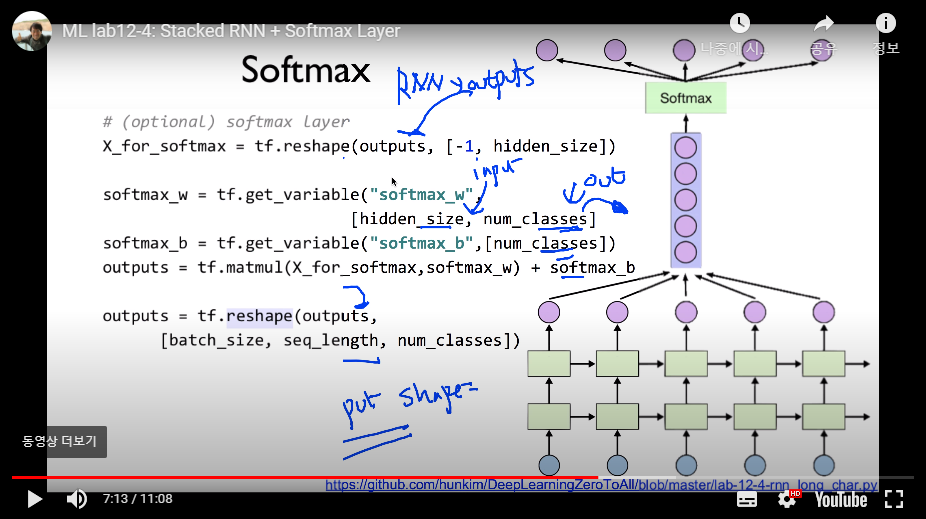

각 sequence의 output을 모아 FC를 이룬 뒤 softmax를 적용한다. 여기서 wide & deep하게 하기 위해 multi_cell을 주목하자. MultiRNNCell에서 BasicLSTM을 몇 층 쌓을건지 정하면 된다. 여기선 2층만 쌓는다.

In [ ]:
# if very long sentence goes in,
sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

In [ ]:
char_set = list(set(sentence))
char_dic = {w: i for i, w in enumerate(char_set)}

In [ ]:
# hyper params (자동화)
data_dim = len(char_set)
hidden_size = len(char_set)
num_classes = len(char_set)
sequence_length = 10    # Any arbitrary number
learning_rate = 0.1

In [ ]:
# Preprocessing (sentence를 10글자씩 끊어서 170개의 x_data, y_data를 준비.)
dataX = []
dataY = []
for i in range(0, len(sentence) - sequence_length):
  x_str = sentence[i: i + sequence_length]
  y_str = sentence[i + 1: i + sequence_length + 1]
  print(i, x_str, ' -> ', y_str)

  x = [char_dic[c] for c in x_str]    # x str -> idx
  y = [char_dic[c] for c in y_str]    # y str -> idx

  dataX.append(x)
  dataY.append(y)

batch_size = len(dataX)

0 if you wan  ->  f you want
1 f you want  ->   you want 
2  you want   ->  you want t
3 you want t  ->  ou want to
4 ou want to  ->  u want to 
5 u want to   ->   want to b
6  want to b  ->  want to bu
7 want to bu  ->  ant to bui
8 ant to bui  ->  nt to buil
9 nt to buil  ->  t to build
10 t to build  ->   to build 
11  to build   ->  to build a
12 to build a  ->  o build a 
13 o build a   ->   build a s
14  build a s  ->  build a sh
15 build a sh  ->  uild a shi
16 uild a shi  ->  ild a ship
17 ild a ship  ->  ld a ship,
18 ld a ship,  ->  d a ship, 
19 d a ship,   ->   a ship, d
20  a ship, d  ->  a ship, do
21 a ship, do  ->   ship, don
22  ship, don  ->  ship, don'
23 ship, don'  ->  hip, don't
24 hip, don't  ->  ip, don't 
25 ip, don't   ->  p, don't d
26 p, don't d  ->  , don't dr
27 , don't dr  ->   don't dru
28  don't dru  ->  don't drum
29 don't drum  ->  on't drum 
30 on't drum   ->  n't drum u
31 n't drum u  ->  't drum up
32 't drum up  ->  t drum up 
33 t drum up   ->   

In [ ]:
X = tf.placeholder(tf.int32, [None, sequence_length])
Y = tf.placeholder(tf.int32, [None, sequence_length])

# One-hot encoding
X_one_hot = tf.one_hot(X, num_classes)
print(X_one_hot)    # check out the shape

# Make a lstm cell w/ hidden_size 9each unit output vector size)
def lstm_cell():
  cell = tf.contrib.rnn.BasicLSTMCell(hidden_size, state_is_tuple=True)
  return cell

# WIDE & DEEP!
multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(2)], state_is_tuple=True)

# outputs: unfoling size x hidden size, state = hidden size
outputs, _states = tf.nn.dynamic_rnn(multi_cells, X_one_hot, dtype=tf.float32)

# FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_size])
outputs = tf.contrib.layers.fully_connected(X_for_fc, num_classes, activation_fn=None)

# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])

# All weights are 1 (equal weights)
weights = tf.ones([batch_size, sequence_length])

sequence_loss = tf.contrib.seq2seq.sequence_loss(
    logits=outputs, targets=Y, weights=weights)
mean_loss = tf.reduce_mean(sequence_loss)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mean_loss)

Tensor("one_hot:0", shape=(?, 10, 25), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(500):
  _, l, results = sess.run(
      [train_op, mean_loss, outputs], feed_dict={X: dataX, Y: dataY})
  for j, result in enumerate(results):
    index = np.argmax(result, axis=1)
    print(i, j, ''.join([char_set[t] for t in index]), 1)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
470 100 , and work 1
470 101 iind work, 1
470 102 tnd dork,  1
470 103 nd dork, b 1
470 104 d dork, bu 1
470 105  aork, but 1
470 106 took, but  1
470 107 ook, but r 1
470 108   , but ra 1
470 109  , but rat 1
470 110 , but rath 1
470 111  but rathe 1
470 112 tui rather 1
470 113 ui rather  1
470 114   rather t 1
470 115  tather te 1
470 116 tather tea 1
470 117  ther teac 1
470 118 nher teach 1
470 119  em teach  1
470 120 em teach t 1
470 121   teach th 1
470 122  thach the 1
470 123 thach them 1
470 124  ach them  1
470 125  ch them t 1
470 126 nh them to 1
470 127 h them to  1
470 128 ethem to l 1
470 129 them to lo 1
470 130  em ta lon 1
470 131 em ta long 1
470 132   ta long  1
470 133  ta long f 1
470 134 th long fo 1
470 135   long for 1
470 136  cong for  1
470 137 tong for t 1
470 138 eng for th 1
470 139  ' for the 1
470 140 d for the  1
470 141  for the e 1
470 142 tor the en 1
470 143  r the end 1
470 144   the endl 1
470 145  the endle 

In [ ]:
# Let's print the last char of each result to check it works
results = sess.run(outputs, feed_dict={X: dataX})
for j, result in enumerate(results):
  index = np.argmax(result, axis=1)
  if j is 0:    # print all for the first result to make a sentence
    print(''.join([char_set[t] for t in index]), end='')
  else:
    print(char_set[index[-1]], end='')

g you want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.

정말 수고했다!! 그런데 처음 글자가 안맞을 것이다... 어쨌든 wide & deep을 지켰으니 이 뒤는 정확하다.

이런 시계열 데이터를 잘 처리만 하면 다음과 같은 일들을 할 수 있다.
* 셰익스피어 문체 따라하기
* 코드가 코드짜기 (심지어 주석도 그럴싸하게 씀 ㄷㄷ)
* 주식시장, 비트코인 예측

예시로 다음 사이트를 둘러보자.
* char/word rnn
> https://github.com/sherjilozair/char-rnn-tensorflow \
> https://github.com/hunkim/word-rnn-tensorflow